# Project 1: Classifying Music Genre by Lyrics


## Download/Import all libraries needed for data preprocessing, training, modeling, and testing

In [16]:
from lyricsgenius import Genius
import os
import json
import re
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

## Load the data.json file 

In [17]:
# Loading the JSON file
with open("data.json", "r", encoding="utf-8") as f:
    data = json.load(f)

## Extract the unique song genres in the dataset

In [18]:
# Extracting all genres from the JSON
genres = []
for song_id, song_info in data.items():
    genres.append(song_info["genre"])

## Count how many songs are in each genre

In [19]:
# Counting how many of each genre
genre_counts = Counter(genres)

## Creating a bar graph showing number of songs in each genre

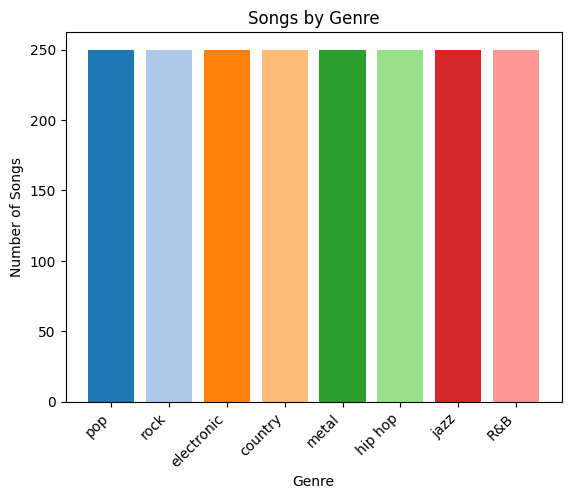

In [20]:
# Plotting a bar chart

colors = plt.cm.tab20.colors  # a palette with 20 distinct colors
bar_colors = [colors[i % len(colors)] for i in range(len(genre_counts))]
plt.bar(genre_counts.keys(), genre_counts.values(), color=bar_colors)
plt.xlabel("Genre")
plt.ylabel("Number of Songs")
plt.title("Songs by Genre")

# Rotate x-axis labels to avoid overlap
plt.xticks(rotation=45, ha='right')

plt.show()

## Sort the songs in the dataset by genre

In [21]:
# Sorting the songs by genre
songs_grouped_by_genre = defaultdict(list)

for song_id, song_info in data.items():
    songs_grouped_by_genre[song_info["genre"]].append(song_info)


## Clean data function removes linebreaks, lowercases the lyrics, and removes special characters and punctuation

In [22]:
# Clean the data and prepare for vectorization
def clean_lyrics(lyrics, 
                 keep_linebreaks=False, 
                 lowercase=True, 
                 remove_punctuation=True):
    """
    Cleans song lyrics for vectorization.

    Parameters:
    - lyrics (str): the raw lyrics
    - keep_linebreaks (bool): whether to keep '\n' for stanza separation
    - lowercase (bool): whether to convert all text to lowercase
    - remove_punctuation (bool): whether to strip punctuation

    Returns:
    - str: cleaned lyrics
    """
    if lyrics is None:
        return ""

    # Replace unicode formatting spaces with normal space
    lyrics = lyrics.replace('\u2005', ' ').replace('\xa0', ' ')

    # Optionally replace newlines with space
    if not keep_linebreaks:
        lyrics = lyrics.replace('\n', ' ')

    # Lowercase
    if lowercase:
        lyrics = lyrics.lower()

    # Remove punctuation
    if remove_punctuation:
        lyrics = re.sub(r"[^\w\s]", "", lyrics)

    # Normalize multiple spaces
    lyrics = re.sub(r"\s+", " ", lyrics).strip()

    return lyrics

for genre in songs_grouped_by_genre:
    current_genre_songs = songs_grouped_by_genre[genre]
    for song in current_genre_songs:
        if song.get("lyrics") is None:
            continue
        song["lyrics"] = clean_lyrics(song["lyrics"])

## Generate word cloud to get general idea of what words are most common in each genre

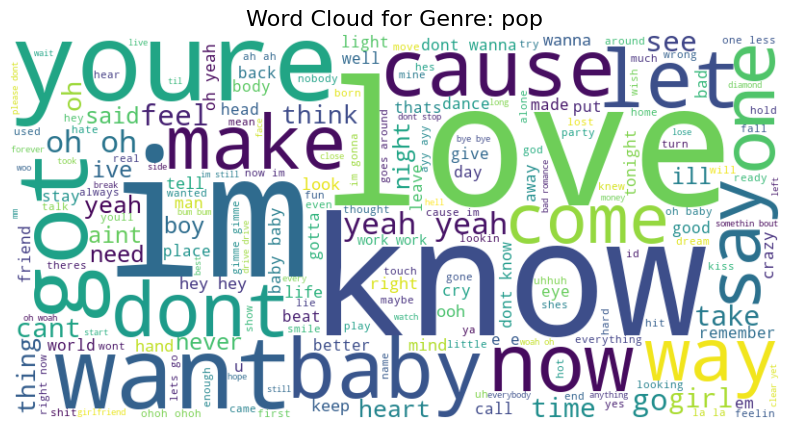

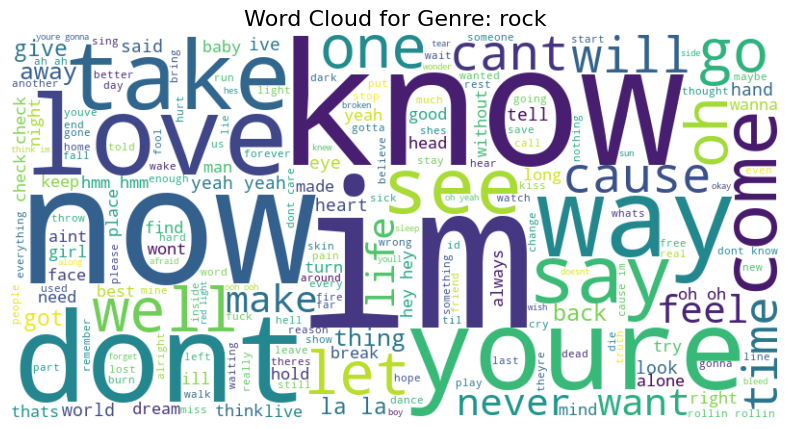

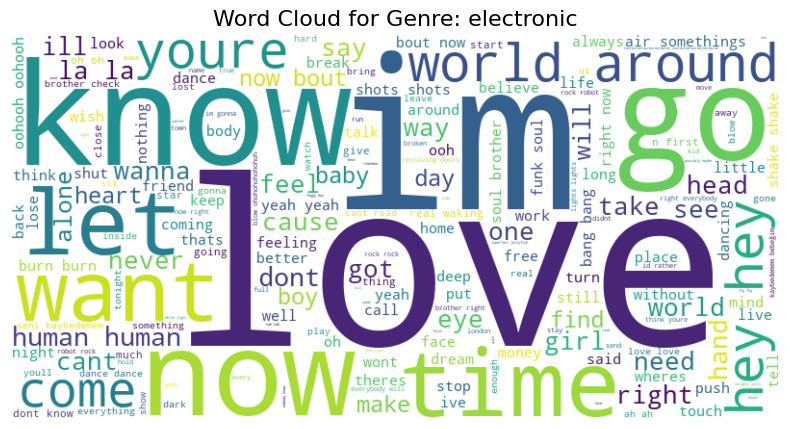

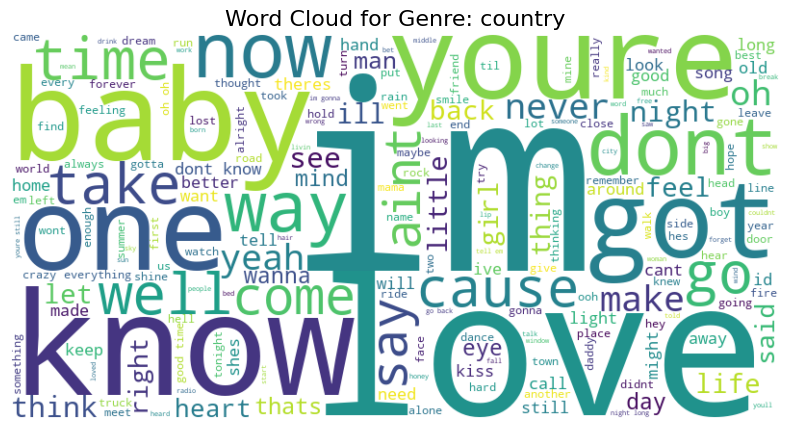

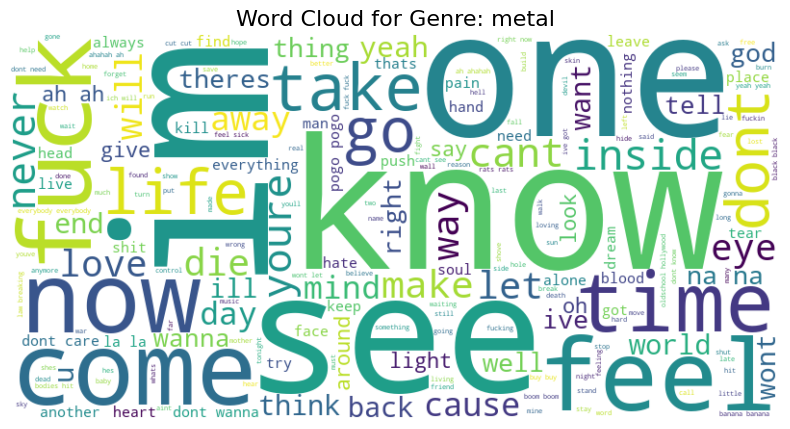

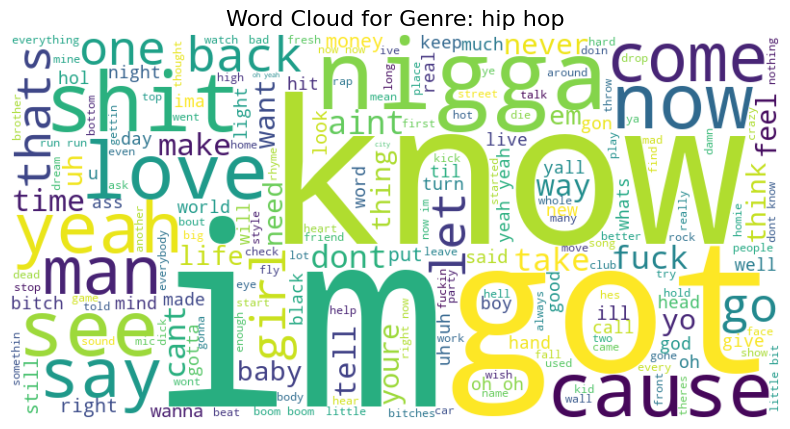

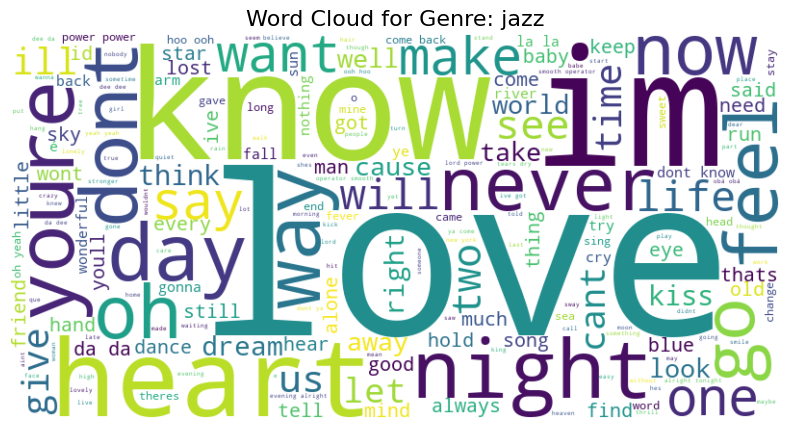

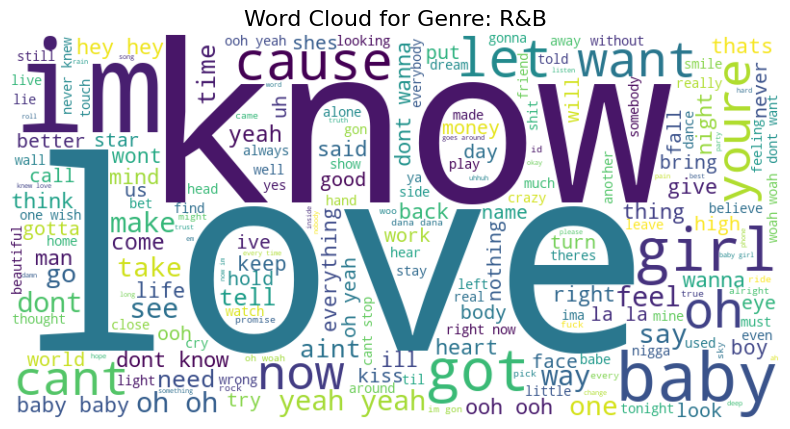

In [23]:
# Generating word cloud for each genre
for genre in songs_grouped_by_genre:
    # Collect all lyrics for this genre into one big string
    lyrics_list = []
    for song in songs_grouped_by_genre[genre]:
        if song.get("lyrics") is not None and song["lyrics"].strip():
            lyrics_list.append(song["lyrics"])
    
    if not lyrics_list:  # skip if no valid lyrics
        continue
    
    lyrics_text = " ".join(lyrics_list)

    # Generate word cloud
    wc = WordCloud(width=800, height=400, background_color="white").generate(lyrics_text)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Genre: {genre}", fontsize=16)
    plt.show()

## What song genre has the most/least words on average?

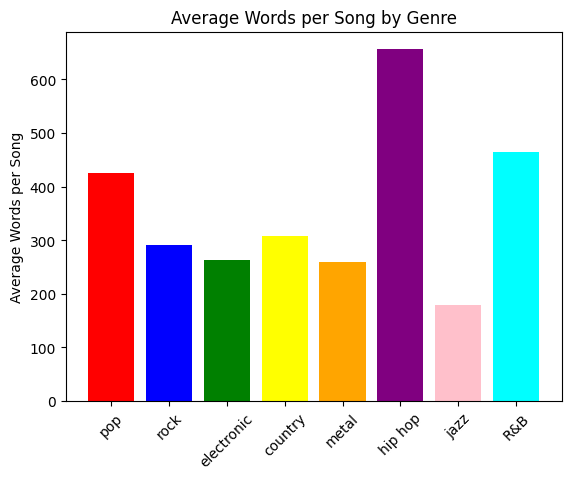

In [24]:
# Average number of words per song for each genre
avg_words_per_genre = {}

for genre, songs in songs_grouped_by_genre.items():
    word_counts = []
    for song in songs:
        lyrics = song.get("lyrics")
        if lyrics and lyrics.strip():  # only count if lyrics exist
            words = lyrics.split()  # split on whitespace
            word_counts.append(len(words))
    
    if word_counts:  # avoid division by zero
        avg_words_per_genre[genre] = sum(word_counts) / len(word_counts)
    else:
        avg_words_per_genre[genre] = 0

plt.bar(avg_words_per_genre.keys(), avg_words_per_genre.values(), color=["red", "blue", "green", "yellow", "orange", "purple", "pink", "aqua"])
plt.ylabel("Average Words per Song")
plt.title("Average Words per Song by Genre")
plt.xticks(rotation=45)
plt.show()

## Split lyrics with their associated genres into separate lists but corresponding indices to vectorize

In [25]:
# tf-idf extract features

# Flatten the dictionary to a list of lyrics and their genres
lyrics_list = []
genres_list = []

for genre, songs in songs_grouped_by_genre.items():
    for song in songs:
        lyrics = song.get("lyrics")
        if lyrics and lyrics.strip():  # only include non-empty lyrics
            lyrics_list.append(lyrics)
            genres_list.append(genre)

tfidf_vectorizer = TfidfVectorizer(
    lowercase=True,        # already done in preprocessing, but safe
    stop_words='english',  # remove common words
    ngram_range=(1, 2),    # unigrams + bigrams
    max_features=5000      # optional: limit to top 5000 features
)

print("How many songs in each genre actually has lyrics:")
print("R&B:", genres_list.count("R&B"))
print("country:", genres_list.count("country"))
print("electronic:", genres_list.count("electronic"))
print("hip hop:", genres_list.count("hip hop"))
print("jazz:", genres_list.count("jazz"))
print("metal:", genres_list.count("metal"))
print("pop:", genres_list.count("pop"))
print("rock:", genres_list.count("rock"))

How many songs in each genre actually has lyrics:
R&B: 250
country: 250
electronic: 228
hip hop: 246
jazz: 176
metal: 250
pop: 250
rock: 246


## Training with 80-20 split on data set, cross validation on training set, test model and compare results

In [26]:
# training and testing

# 1. Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    lyrics_list, genres_list, test_size=0.2, random_state=42, stratify=genres_list
)

# 2. Build pipeline (vectorizer + classifier)
pipeline = Pipeline([
    ("tfidf", tfidf_vectorizer),
    ("clf", LogisticRegression(max_iter=1000))
])

# 3. Cross-validation on training set
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring="accuracy")
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())

# 4. Train on full training set
pipeline.fit(X_train, y_train)

# 5. Evaluate on test set
y_pred = pipeline.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

Cross-validation scores: [0.43092105 0.4620462  0.44884488 0.3960396  0.37623762]
Mean CV accuracy: 0.4228178738926524
Test accuracy: 0.42105263157894735

Classification report:
               precision    recall  f1-score   support

         R&B       0.37      0.44      0.40        50
     country       0.51      0.70      0.59        50
  electronic       0.32      0.17      0.23        46
     hip hop       0.59      0.66      0.62        50
        jazz       0.58      0.40      0.47        35
       metal       0.42      0.44      0.43        50
         pop       0.24      0.22      0.23        50
        rock       0.31      0.31      0.31        49

    accuracy                           0.42       380
   macro avg       0.42      0.42      0.41       380
weighted avg       0.41      0.42      0.41       380



## Confusion matrix to visualize performance and check anomalies between genres

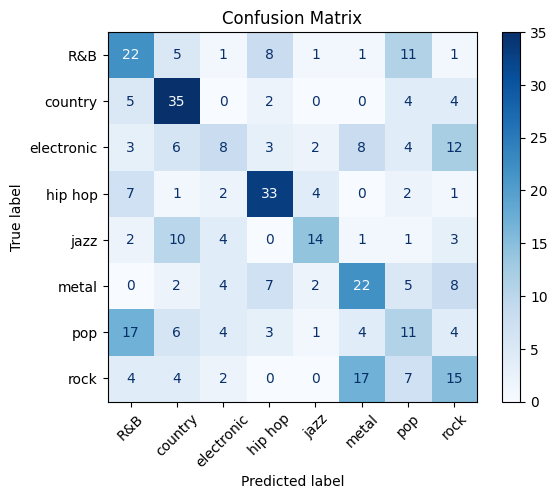

In [27]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)

# Display confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

## More visualization on model performance by comparing predicted genre to true genre of some song lyrics

In [28]:
# View specific examples comparing actual genres with model classification

# After training and predicting:
y_pred = pipeline.predict(X_test)

# Build a DataFrame to compare
results_df = pd.DataFrame({
    "Lyrics": X_test,          # raw lyrics text
    "True Genre": y_test,
    "Predicted Genre": y_pred
})

# Show a few random examples
print(results_df.sample(10, random_state=42))

                                                Lyrics  True Genre  \
266  in a few weeks i will get time to realise its ...  electronic   
261  education fornication in you are go education ...       metal   
265  fallin dreamin talkin in your sleep i know you...     hip hop   
39   oh oh oh oh oh her eyes her eyes make the star...         R&B   
33   let me know that ive done wrong when ive known...        rock   
363  do the dance one two three four fight stick to...  electronic   
55   ah ah ah loving you is complicated loving you ...     hip hop   
262  driving this road down to paradise letting the...  electronic   
311  heading down south to the land of the pines im...     country   
168  dont rock the jukebox i wanna hear some jones ...     country   

    Predicted Genre  
266             pop  
261             pop  
265         hip hop  
39              pop  
33          country  
363            rock  
55          hip hop  
262            rock  
311         hip hop  
168      

## Check what words had the most influence on the model to predict a certain genre

In [31]:
# Extract the trained TF-IDF vectorizer and classifier from the pipeline
vectorizer = pipeline.named_steps["tfidf"]
clf = pipeline.named_steps["clf"]

# Get feature names (words/phrases)
feature_names = vectorizer.get_feature_names_out()

for i, genre in enumerate(clf.classes_):
    # Get top 10 words with highest positive coefficients for this genre
    top10 = np.argsort(clf.coef_[i])[-10:]
    print(f"\nTop words for genre '{genre}':")
    for idx in reversed(top10):
        print(f"  {feature_names[idx]} ({clf.coef_[i][idx]:.3f})")



Top words for genre 'R&B':
  baby (2.764)
  girl (2.240)
  ooh (1.984)
  love (1.527)
  yeah (1.458)
  oh (1.365)
  aint (1.031)
  cause (0.963)
  babe (0.914)
  want (0.914)

Top words for genre 'country':
  country (1.724)
  little (1.723)
  man (1.269)
  road (1.219)
  old (1.216)
  beer (1.059)
  night (1.057)
  long (1.032)
  cowboy (1.022)
  gonna (1.002)

Top words for genre 'electronic':
  enjoy (0.902)
  eyes (0.890)
  think youre (0.847)
  command (0.742)
  love love (0.717)
  human (0.684)
  girls (0.674)
  뛰어 (0.672)
  human human (0.667)
  broken (0.639)

Top words for genre 'hip hop':
  shit (2.440)
  niggas (2.212)
  nigga (2.208)
  uh (1.936)
  bitch (1.828)
  fuck (1.811)
  yo (1.736)
  like (1.583)
  yall (1.356)
  money (1.235)

Top words for genre 'jazz':
  love (1.896)
  heart (1.829)
  que (1.352)
  wonderful (1.213)
  sweet (1.141)
  new (1.098)
  blue (1.097)
  kick (1.073)
  river (1.009)
  dear (1.003)

Top words for genre 'metal':
  die (1.720)
  inside (1.5

## Look at the probabilities the model assigned for each genre for a specific song

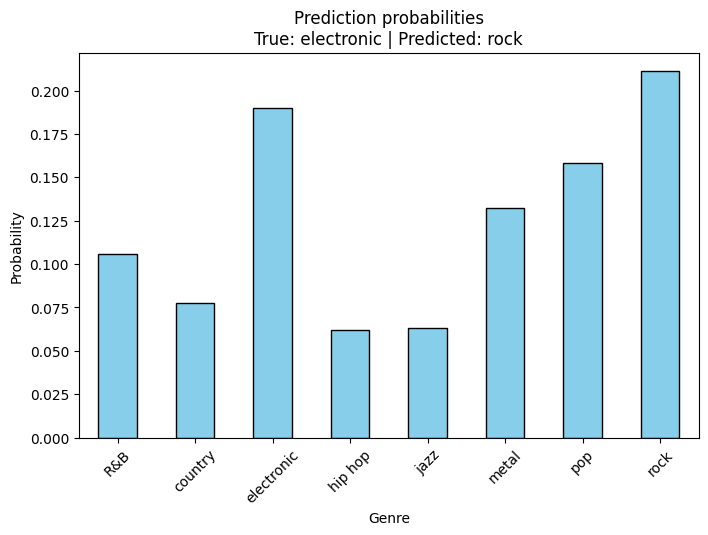

Song: "Heads will roll" by the Yeah Yeah Yeahs
Lyrics snippet: off with your head dance til youre dead heads will roll heads will roll heads will roll on the floor glitter on the wet streets silver over everything the rivers all wet youre all chrome dripping with ...


In [32]:
# Get probabilities for each class (genre)
probas = pipeline.predict_proba(X_test)

# Wrap into a DataFrame for convenience
probas_df = pd.DataFrame(probas, columns=clf.classes_)
probas_df["True Genre"] = y_test
probas_df["Predicted Genre"] = y_pred
probas_df["Lyrics"] = X_test

# Filter misclassified songs
mistakes = probas_df[probas_df["True Genre"] != probas_df["Predicted Genre"]]

# Pick one misclassified example
example = mistakes.sample(1, random_state=42).iloc[0]

# Bar chart
plt.figure(figsize=(8, 5))
example[clf.classes_].plot(kind="bar", color="skyblue", edgecolor="black")

plt.title(f"Prediction probabilities\nTrue: {example['True Genre']} | Predicted: {example['Predicted Genre']}")
plt.ylabel("Probability")
plt.xlabel("Genre")
plt.xticks(rotation=45)
plt.show()

# Show lyric snippet for context
print("Song: \"Heads will roll\" by the Yeah Yeah Yeahs")
print("Lyrics snippet:", example["Lyrics"][:200], "...")